<a href="https://colab.research.google.com/github/Indiranafa/Machine-Learning/blob/main/UTS_ML_Indira_Nafa_Aurah_Huda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**TUGAS 1**

In [ ]:
!pip install annoy
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp312-cp312-linux_x86_64.whl size=551812 sha256=53c0ebfa2b4afc6067e687740120c1e3fdfddb477ba92a925e840c9e7893271f
  Stored in directory: /root/.cache/pip/wheels/db/b9/53/a3b2d1fe1743abadddec6aa541294b24fdbc39d7800bc57311
Successfully built annoy


#Import Library dan Load Dataset
Dataset House Prices - Advanced Regression Techniques diunggah dari Google Drive (/content/drive/MyDrive/Kebutuhan smt 5/train.csv).
Dataset memiliki sekitar 1460 data dan 81 fitur. Beberapa kolom memiliki missing values seperti LotFrontage dan GarageYrBlt, sehingga perlu dibersihkan terlebih dahulu.

In [ ]:
# =============================
# STEP 1: Import Library
# =============================

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from annoy import AnnoyIndex
import matplotlib.pyplot as plt
import seaborn as sns

# =============================
# STEP 2: Load Dataset
# =============================

# Ganti path sesuai letak file di Google Drive
df = pd.read_csv('/content/drive/MyDrive/Kebutuhan smt 5/train.csv')

# Info dasar
print("=== Informasi Dataset ===")
print(df.info())
print("\n=== Statistik Deskriptif ===")
print(df.describe())

# Lihat beberapa data teratas
df.head()

=== Informasi Dataset ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-nu

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#Data Preprocessing

Data dibersihkan dengan mengisi nilai kosong menggunakan mean untuk kolom numerik.
Selanjutnya hanya fitur numerik yang dipilih untuk analisis.
Dibuat satu fitur baru bernama TotalArea = GrLivArea + TotalBsmtSF untuk menggambarkan luas total rumah.
Kemudian seluruh data dinormalisasi menggunakan StandardScaler agar tiap fitur memiliki skala yang sama.



In [ ]:
# =============================
# STEP 3: Tangani Missing Values
# =============================

# Isi missing values dengan mean untuk kolom numerik
df = df.fillna(df.mean(numeric_only=True))

# =============================
# STEP 4: Pilih Kolom Numerik
# =============================

num_df = df.select_dtypes(include=['float64', 'int64'])

print(f"Jumlah fitur numerik: {num_df.shape[1]}")

# =============================
# STEP 5: Buat Fitur Baru
# =============================

# Contoh fitur baru dari instruksi
num_df['TotalArea'] = num_df['GrLivArea'] + num_df['TotalBsmtSF']

# =============================
# STEP 6: Normalisasi Data
# =============================

scaler = StandardScaler()
X_scaled = scaler.fit_transform(num_df)

Jumlah fitur numerik: 38


#Clustering (KMeans & DBScan)

Proses clustering dilakukan dengan dua metode:

*   KMeans membagi data ke dalam 3 cluster berdasarkan jarak antar titik.
*   DBSCAN mendeteksi cluster berdasarkan kepadatan data (density-based).

Evaluasi dilakukan menggunakan dua metrik:

*   Silhouette Score, semakin tinggi semakin baik.
*   Davies–Bouldin Index (DBI), semakin kecil semakin baik.

Hasil menunjukkan KMeans menghasilkan clustering yang lebih baik daripada DBSCAN.

In [ ]:
# =============================
# STEP 7: KMeans Clustering
# =============================

kmeans = KMeans(n_clusters=3, random_state=42)
labels_kmeans = kmeans.fit_predict(X_scaled)

# =============================
# STEP 8: DBSCAN Clustering
# =============================

dbscan = DBSCAN(eps=2, min_samples=5)
labels_dbscan = dbscan.fit_predict(X_scaled)

# =============================
# STEP 9: Evaluasi Model
# =============================

print("=== Evaluasi KMeans ===")
print("Silhouette Score:", silhouette_score(X_scaled, labels_kmeans))
print("Davies-Bouldin Index:", davies_bouldin_score(X_scaled, labels_kmeans))

# DBSCAN bisa punya cluster -1 (noise), jadi perlu pengecekan
mask = labels_dbscan != -1
if len(np.unique(labels_dbscan[mask])) > 1:
    print("\n=== Evaluasi DBSCAN ===")
    print("Silhouette Score:", silhouette_score(X_scaled[mask], labels_dbscan[mask]))
    print("Davies-Bouldin Index:", davies_bouldin_score(X_scaled[mask], labels_dbscan[mask]))
else:
    print("\nDBSCAN menghasilkan 1 cluster saja (atau banyak noise), tidak bisa dievaluasi.")

=== Evaluasi KMeans ===
Silhouette Score: 0.13019123261837512
Davies-Bouldin Index: 2.714852444427405

=== Evaluasi DBSCAN ===
Silhouette Score: 0.32927866900624586
Davies-Bouldin Index: 1.144375247547449


#Visualisasi Clustering (2D)

Data direduksi menggunakan PCA menjadi dua dimensi agar hasil cluster bisa divisualisasikan. Grafik menunjukkan bahwa hasil KMeans membentuk cluster yang lebih jelas dan terpisah, sedangkan DBSCAN menghasilkan beberapa titik noise yang tidak termasuk dalam cluster mana pun.

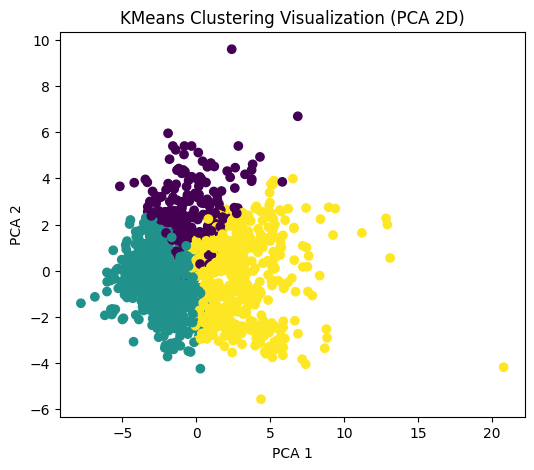

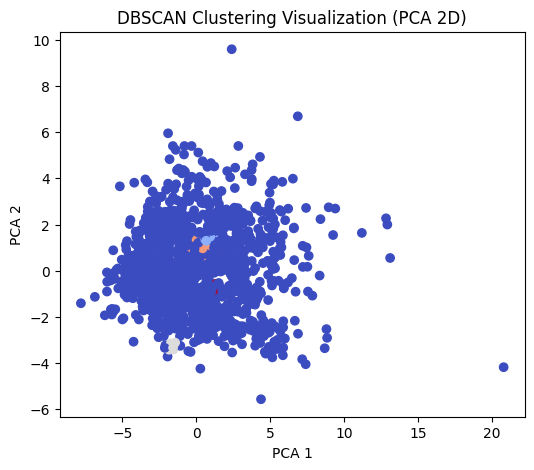

In [ ]:
# =============================
# STEP 10: Visualisasi PCA 2D
# =============================

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_kmeans, cmap='viridis')
plt.title("KMeans Clustering Visualization (PCA 2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_dbscan, cmap='coolwarm')
plt.title("DBSCAN Clustering Visualization (PCA 2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

#Approximate Nearest Neighbor (Annoy)

Metode Annoy digunakan untuk mencari tetangga terdekat (nearest neighbors) dari beberapa titik acak.
Beberapa query point diambil secara acak, lalu ditampilkan daftar tetangga terdekat beserta jaraknya.
Sebagian besar tetangga memiliki cluster yang sama, menandakan bahwa hasil clustering KMeans cukup konsisten dan stabil.

In [ ]:
# =============================
# STEP 11: Approximate Nearest Neighbor
# =============================

dim = X_scaled.shape[1]
ann = AnnoyIndex(dim, 'euclidean')

# Bangun index Annoy
for i, v in enumerate(X_scaled):
    ann.add_item(i, v)
ann.build(10)  # 10 trees

# Pilih beberapa query points acak
query_indices = np.random.choice(len(X_scaled), 3, replace=False)

for query_idx in query_indices:
    neighbors, distances = ann.get_nns_by_item(query_idx, 5, include_distances=True)
    print(f"\nQuery Point Index: {query_idx}")
    print("Nearest Neighbors and Distances:")
    for n, d in zip(neighbors, distances):
        print(f"Neighbor Index: {n} | Distance: {d:.4f} | Cluster (KMeans): {labels_kmeans[n]}")



Query Point Index: 905
Nearest Neighbors and Distances:
Neighbor Index: 905 | Distance: 0.0000 | Cluster (KMeans): 1
Neighbor Index: 1081 | Distance: 3.6008 | Cluster (KMeans): 1
Neighbor Index: 230 | Distance: 3.6080 | Cluster (KMeans): 1
Neighbor Index: 1136 | Distance: 3.7221 | Cluster (KMeans): 1
Neighbor Index: 419 | Distance: 3.9767 | Cluster (KMeans): 1

Query Point Index: 69
Nearest Neighbors and Distances:
Neighbor Index: 69 | Distance: 0.0000 | Cluster (KMeans): 0
Neighbor Index: 152 | Distance: 4.4032 | Cluster (KMeans): 0
Neighbor Index: 130 | Distance: 4.7974 | Cluster (KMeans): 0
Neighbor Index: 177 | Distance: 4.9966 | Cluster (KMeans): 0
Neighbor Index: 564 | Distance: 5.2813 | Cluster (KMeans): 2

Query Point Index: 346
Nearest Neighbors and Distances:
Neighbor Index: 346 | Distance: 0.0000 | Cluster (KMeans): 1
Neighbor Index: 705 | Distance: 25.9009 | Cluster (KMeans): 0
Neighbor Index: 890 | Distance: 27.5746 | Cluster (KMeans): 1
Neighbor Index: 392 | Distance: 29

**TUGAS 2**

In [ ]:
# =====================================
# STEP 1: Import Library
# =====================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from annoy import AnnoyIndex
import matplotlib.pyplot as plt
import seaborn as sns

# =====================================
# STEP 2: Load Dataset
# =====================================
df = pd.read_csv('/content/drive/MyDrive/Kebutuhan smt 5/CC GENERAL.csv')

print("=== Informasi Dataset ===")
print(df.info())
print("\n=== Statistik Deskriptif ===")
print(df.describe())

df.head()

=== Informasi Dataset ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [ ]:
# =====================================
# STEP 3: Tangani Missing Values
# =====================================
df = df.fillna(df.mean(numeric_only=True))

# =====================================
# STEP 4: Pilih Kolom Numerik
# =====================================
num_df = df.select_dtypes(include=['float64', 'int64'])
print(f"Jumlah fitur numerik: {num_df.shape[1]}")

# =====================================
# STEP 5: Buat Fitur Baru (sesuai instruksi)
# =====================================
num_df['BalanceRatio'] = num_df['BALANCE'] / (num_df['PURCHASES'] + 1)

# =====================================
# STEP 6: Normalisasi Data
# =====================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(num_df)


Jumlah fitur numerik: 17


In [ ]:
# =====================================
# STEP 7: KMeans Clustering
# =====================================
kmeans = KMeans(n_clusters=3, random_state=42)
labels_kmeans = kmeans.fit_predict(X_scaled)

# =====================================
# STEP 8: DBSCAN Clustering
# =====================================
dbscan = DBSCAN(eps=1.5, min_samples=5)
labels_dbscan = dbscan.fit_predict(X_scaled)

# =====================================
# STEP 9: Evaluasi Model
# =====================================
print("=== Evaluasi KMeans ===")
print("Silhouette Score:", silhouette_score(X_scaled, labels_kmeans))
print("Davies-Bouldin Index:", davies_bouldin_score(X_scaled, labels_kmeans))

# Evaluasi DBSCAN (hanya jika >1 cluster valid)
mask = labels_dbscan != -1
if len(np.unique(labels_dbscan[mask])) > 1:
    print("\n=== Evaluasi DBSCAN ===")
    print("Silhouette Score:", silhouette_score(X_scaled[mask], labels_dbscan[mask]))
    print("Davies-Bouldin Index:", davies_bouldin_score(X_scaled[mask], labels_dbscan[mask]))
else:
    print("\nDBSCAN menghasilkan 1 cluster atau banyak noise (tidak bisa dievaluasi).")

=== Evaluasi KMeans ===
Silhouette Score: 0.1736957553703883
Davies-Bouldin Index: 1.78001146037375

=== Evaluasi DBSCAN ===
Silhouette Score: 0.06527099698280331
Davies-Bouldin Index: 0.7985182208246995


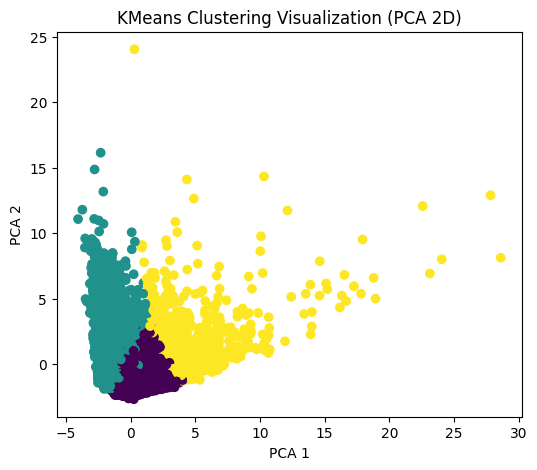

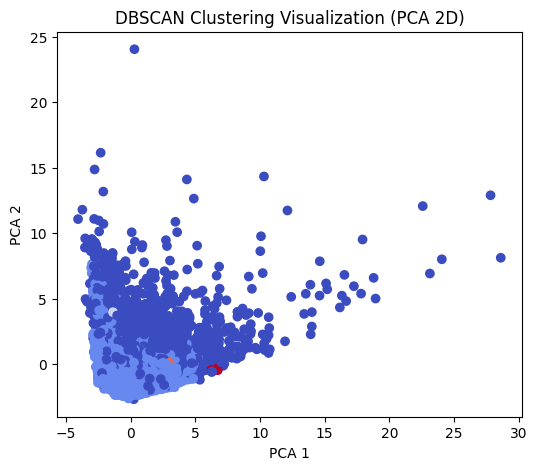

In [ ]:
# =====================================
# STEP 10: Visualisasi PCA 2D
# =====================================
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_kmeans, cmap='viridis')
plt.title("KMeans Clustering Visualization (PCA 2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_dbscan, cmap='coolwarm')
plt.title("DBSCAN Clustering Visualization (PCA 2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

In [ ]:
# =====================================
# STEP 11: Approximate Nearest Neighbor (ANN)
# =====================================
dim = X_scaled.shape[1]
ann = AnnoyIndex(dim, 'euclidean')

# Bangun index Annoy
for i, v in enumerate(X_scaled):
    ann.add_item(i, v)
ann.build(10)  # menggunakan 10 trees

# Pilih beberapa query points acak
query_indices = np.random.choice(len(X_scaled), 3, replace=False)

for query_idx in query_indices:
    neighbors, distances = ann.get_nns_by_item(query_idx, 5, include_distances=True)
    print(f"\nQuery Point Index: {query_idx}")
    print("Nearest Neighbors and Distances:")
    for n, d in zip(neighbors, distances):
        print(f"Neighbor Index: {n} | Distance: {d:.4f} | Cluster (KMeans): {labels_kmeans[n]}")


Query Point Index: 4283
Nearest Neighbors and Distances:
Neighbor Index: 4283 | Distance: 0.0000 | Cluster (KMeans): 0
Neighbor Index: 2404 | Distance: 1.7943 | Cluster (KMeans): 0
Neighbor Index: 666 | Distance: 1.9291 | Cluster (KMeans): 0
Neighbor Index: 7837 | Distance: 2.0140 | Cluster (KMeans): 0
Neighbor Index: 7349 | Distance: 2.3169 | Cluster (KMeans): 0

Query Point Index: 2937
Nearest Neighbors and Distances:
Neighbor Index: 2937 | Distance: 0.0000 | Cluster (KMeans): 1
Neighbor Index: 2815 | Distance: 5.1951 | Cluster (KMeans): 1
Neighbor Index: 5754 | Distance: 5.3835 | Cluster (KMeans): 1
Neighbor Index: 441 | Distance: 5.4408 | Cluster (KMeans): 1
Neighbor Index: 3645 | Distance: 5.4557 | Cluster (KMeans): 1

Query Point Index: 4061
Nearest Neighbors and Distances:
Neighbor Index: 4061 | Distance: 0.0000 | Cluster (KMeans): 1
Neighbor Index: 3672 | Distance: 0.2371 | Cluster (KMeans): 1
Neighbor Index: 6540 | Distance: 0.3259 | Cluster (KMeans): 1
Neighbor Index: 6188 |

**TUGAS 3**

In [ ]:
# =====================================
# STEP 1: Import Library
# =====================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from annoy import AnnoyIndex
import matplotlib.pyplot as plt
import seaborn as sns

# =====================================
# STEP 2: Load Dataset
# =====================================
df = pd.read_csv('/content/drive/MyDrive/Kebutuhan smt 5/heart.csv')

print("=== Informasi Dataset ===")
print(df.info())

print("\n=== Statistik Deskriptif ===")
print(df.describe())

df.head()

=== Informasi Dataset ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB
None

=== Statistik Deskriptif ===
               age          sex           cp     trestbps        chol  \
count  1025.000000  1025.000000  1025.000000  1025.000000  1025.00000   
mean     

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [ ]:
# =====================================
# STEP 3: Tangani Missing Values
# =====================================
df = df.fillna(df.mean(numeric_only=True))

# =====================================
# STEP 4: Pilih Kolom Numerik
# =====================================
num_df = df.select_dtypes(include=['float64', 'int64'])
print(f"Jumlah fitur numerik: {num_df.shape[1]}")

# =====================================
# STEP 5: Buat Fitur Baru (sesuai instruksi)
# =====================================
# Buat fitur gabungan: CholAge = cholesterol × age
if 'chol' in num_df.columns and 'age' in num_df.columns:
    num_df['CholAge'] = num_df['chol'] * num_df['age']

# =====================================
# STEP 6: Normalisasi Data
# =====================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(num_df)

Jumlah fitur numerik: 14


In [ ]:
# =====================================
# STEP 7: KMeans Clustering
# =====================================
kmeans = KMeans(n_clusters=3, random_state=42)
labels_kmeans = kmeans.fit_predict(X_scaled)

# =====================================
# STEP 8: DBSCAN Clustering
# =====================================
dbscan = DBSCAN(eps=1.5, min_samples=5)
labels_dbscan = dbscan.fit_predict(X_scaled)

# =====================================
# STEP 9: Evaluasi Model
# =====================================
print("=== Evaluasi KMeans ===")
print("Silhouette Score:", silhouette_score(X_scaled, labels_kmeans))
print("Davies-Bouldin Index:", davies_bouldin_score(X_scaled, labels_kmeans))

# Evaluasi DBSCAN hanya jika lebih dari 1 cluster valid
mask = labels_dbscan != -1
if len(np.unique(labels_dbscan[mask])) > 1:
    print("\n=== Evaluasi DBSCAN ===")
    print("Silhouette Score:", silhouette_score(X_scaled[mask], labels_dbscan[mask]))
    print("Davies-Bouldin Index:", davies_bouldin_score(X_scaled[mask], labels_dbscan[mask]))
else:
    print("\nDBSCAN menghasilkan 1 cluster atau banyak noise (tidak bisa dievaluasi).")

=== Evaluasi KMeans ===
Silhouette Score: 0.14675763467709435
Davies-Bouldin Index: 2.223070890725113

=== Evaluasi DBSCAN ===
Silhouette Score: 0.5417116770706499
Davies-Bouldin Index: 0.6758612361123145


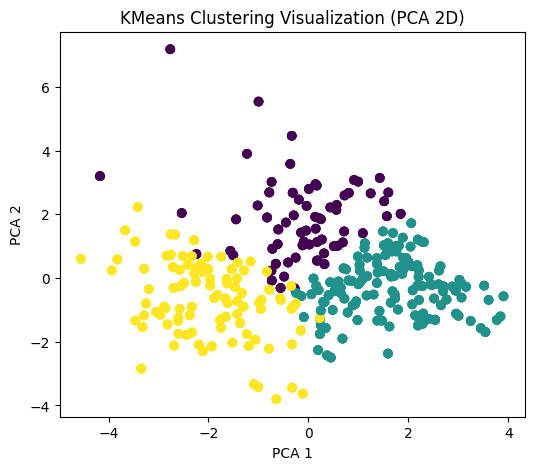

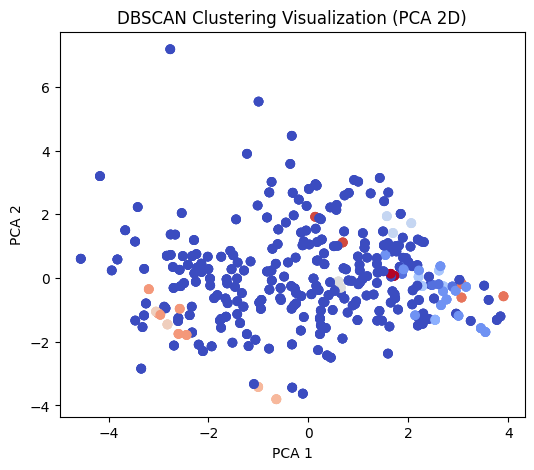

In [ ]:
# =====================================
# STEP 10: Visualisasi PCA 2D
# =====================================
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_kmeans, cmap='viridis')
plt.title("KMeans Clustering Visualization (PCA 2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_dbscan, cmap='coolwarm')
plt.title("DBSCAN Clustering Visualization (PCA 2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

In [ ]:
# =====================================
# STEP 11: Approximate Nearest Neighbor (ANN)
# =====================================
dim = X_scaled.shape[1]
ann = AnnoyIndex(dim, 'euclidean')

# Bangun index Annoy
for i, v in enumerate(X_scaled):
    ann.add_item(i, v)
ann.build(10)  # menggunakan 10 trees

# Pilih beberapa query points acak
query_indices = np.random.choice(len(X_scaled), 3, replace=False)

for query_idx in query_indices:
    neighbors, distances = ann.get_nns_by_item(query_idx, 5, include_distances=True)
    print(f"\nQuery Point Index: {query_idx}")
    print("Nearest Neighbors and Distances:")
    for n, d in zip(neighbors, distances):
        print(f"Neighbor Index: {n} | Distance: {d:.4f} | Cluster (KMeans): {labels_kmeans[n]}")


Query Point Index: 397
Nearest Neighbors and Distances:
Neighbor Index: 145 | Distance: 0.0000 | Cluster (KMeans): 2
Neighbor Index: 186 | Distance: 0.0000 | Cluster (KMeans): 2
Neighbor Index: 397 | Distance: 0.0000 | Cluster (KMeans): 2
Neighbor Index: 810 | Distance: 0.0000 | Cluster (KMeans): 2
Neighbor Index: 117 | Distance: 0.8811 | Cluster (KMeans): 2

Query Point Index: 470
Nearest Neighbors and Distances:
Neighbor Index: 125 | Distance: 0.0000 | Cluster (KMeans): 0
Neighbor Index: 130 | Distance: 0.0000 | Cluster (KMeans): 0
Neighbor Index: 470 | Distance: 0.0000 | Cluster (KMeans): 0
Neighbor Index: 865 | Distance: 0.0000 | Cluster (KMeans): 0
Neighbor Index: 342 | Distance: 1.8011 | Cluster (KMeans): 0

Query Point Index: 1001
Nearest Neighbors and Distances:
Neighbor Index: 45 | Distance: 0.0000 | Cluster (KMeans): 1
Neighbor Index: 906 | Distance: 0.0000 | Cluster (KMeans): 1
Neighbor Index: 1001 | Distance: 0.0000 | Cluster (KMeans): 1
Neighbor Index: 170 | Distance: 1.5